# ADHD EEG Signal Classification - EEGNet(without ICA)

In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


2025-06-24 14:20:38.714889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750774838.923518      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750774838.982372      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

# Load dataset
df = pd.read_csv("adhdata.csv")
print("Dataset shape:", df.shape)
print("Columns:", df.columns)


Dataset shape: (2166383, 21)
Columns: Index(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID'],
      dtype='object')


In [3]:

# Encode class labels
df['Class'] = LabelEncoder().fit_transform(df['Class'])  # ADHD -> 1, Control -> 0
X = df.drop(['Class', 'ID'], axis=1).values
y = df['Class'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [4]:
df

,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,F8,T7,T8,P7,P8,Fz,Cz,Pz,Class,ID
0,261.0,402.0,16.0,261.0,126.0,384.0,126.0,236.0,52.0,236.0,...,16.0,200.0,494.0,126.0,236.0,121.0,367.0,121.0,0,v10p
1,121.0,191.0,-94.0,85.0,16.0,200.0,126.0,52.0,347.0,273.0,...,-57.0,126.0,347.0,52.0,52.0,15.0,121.0,-19.0,0,v10p
2,-55.0,85.0,-204.0,15.0,-57.0,200.0,52.0,126.0,236.0,200.0,...,-94.0,126.0,420.0,52.0,126.0,-55.0,261.0,85.0,0,v10p
3,191.0,85.0,52.0,50.0,89.0,236.0,163.0,89.0,89.0,89.0,...,-57.0,236.0,420.0,126.0,126.0,15.0,85.0,-55.0,0,v10p
4,-55.0,-125.0,-204.0,-160.0,-204.0,16.0,-241.0,-241.0,89.0,16.0,...,-131.0,89.0,310.0,-57.0,52.0,-55.0,15.0,-336.0,0,v10p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166378,15.0,50.0,89.0,85.0,16.0,52.0,-20.0,-20.0,89.0,89.0,...,163.0,126.0,163.0,89.0,163.0,50.0,226.0,121.0,1,v310
2166379,297.0,297.0,347.0,332.0,236.0,347.0,236.0,273.0,273.0,273.0,...,347.0,163.0,347.0,236.0,347.0,332.0,85.0,156.0,1,v310
2166380,121.0,-19.0,52.0,-19.0,-94.0,-20.0,-20.0,16.0,16.0,16.0,...,52.0,-20.0,-20.0,16.0,16.0,191.0,-195.0,-90.0,1,v310
2166381,121.0,15.0,200.0,50.0,126.0,163.0,126.0,236.0,163.0,420.0,...,200.0,163.0,384.0,200.0,384.0,15.0,226.0,226.0,1,v310


In [7]:
import numpy as np
import pandas as pd

def sample_eegnet(df, window_size=128, stride=64):
    eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4',
                    'P3', 'P4', 'O1', 'O2', 'F7', 'F8',
                    'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']

    X_list, y_list = [], []

    for subject_id in df['ID'].unique():
        subject_df = df[df['ID'] == subject_id]
        label = subject_df['Class'].iloc[0]
        signal = subject_df[eeg_channels].to_numpy().T  # shape: (channels, time)

        total_length = signal.shape[1]
        num_windows = (total_length - window_size) // stride + 1

        for i in range(num_windows):
            start = i * stride
            end = start + window_size
            if end <= total_length:
                window = signal[:, start:end]  # (channels, window_size)
                X_list.append(window)
                y_list.append(label)

    X = np.array(X_list)  # shape: (N, channels, window)
    y = np.array(y_list)  # shape: (N,)
    X = X[:, np.newaxis, :, :]  # EEGNet expects: (N, 1, channels, time)

    return X, y



In [8]:
X, y = sample_eegnet(df, window_size=128, stride=64)
print("X shape:", X.shape)  # (N, 1, 19, 128)
print("y shape:", y.shape)


X shape: (33676, 1, 19, 128)
y shape: (33676,)


In [9]:
from collections import Counter
print(Counter(y))  # 예: {0: 5200, 1: 5034}


Counter({0: 18773, 1: 14903})


In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# EEGNet Model Definition
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()

        # Layer 1: Temporal Conv
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 64), padding=(0, 32))
        self.batchnorm1 = nn.BatchNorm2d(16)

        # Layer 2: Depthwise Spatial Conv
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(19, 1), groups=16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.AvgPool2d(kernel_size=(1, 4))

        # Layer 3: Separable Conv
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(0.5)
        )

        # FC Layer (64×1×4 → 256)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = F.elu(self.batchnorm1(self.conv1(x)))
        x = F.elu(self.batchnorm2(self.conv2(x)))
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.classifier(x)
        return x


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Load your data
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape (N, 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, stratify=y, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)


# Training Setup
net = EEGNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

Using device: cuda


In [11]:
from tqdm import tqdm

epochs = 15
for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    
    for xb, yb in loop:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = net(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}")


Epoch 1/15, Avg Loss: 0.2788


Epoch 2/15, Avg Loss: 0.0853


Epoch 3/15, Avg Loss: 0.0568


Epoch 4/15, Avg Loss: 0.0391


Epoch 5/15, Avg Loss: 0.0346


Epoch 6/15, Avg Loss: 0.0289


Epoch 7/15, Avg Loss: 0.0246


Epoch 8/15, Avg Loss: 0.0226


Epoch 9/15, Avg Loss: 0.0202


Epoch 10/15, Avg Loss: 0.0130


Epoch 11/15, Avg Loss: 0.0209


Epoch 12/15, Avg Loss: 0.0164


Epoch 13/15, Avg Loss: 0.0214


Epoch 14/15, Avg Loss: 0.0148


Epoch 15/15, Avg Loss: 0.0104



Evaluation Results:
Accuracy: 0.9985154394299287
Confusion Matrix:
 [[3754    1]
 [   9 2972]]
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9976    0.9997    0.9987      3755
         1.0     0.9997    0.9970    0.9983      2981

    accuracy                         0.9985      6736
   macro avg     0.9986    0.9984    0.9985      6736
weighted avg     0.9985    0.9985    0.9985      6736



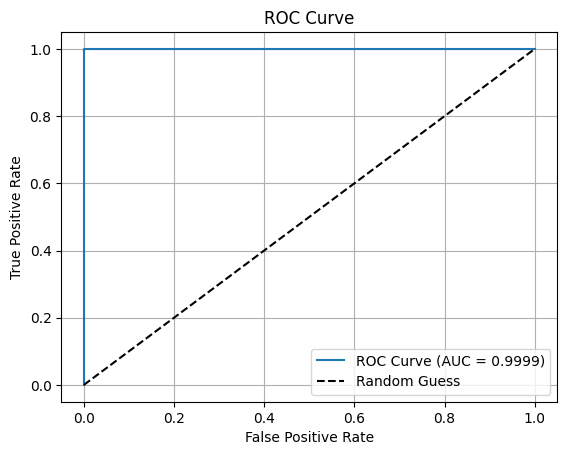

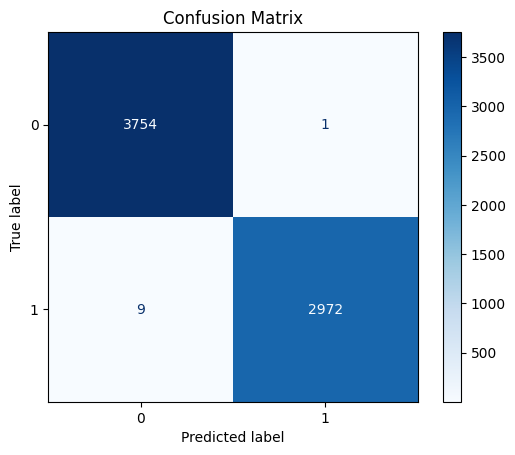

In [13]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, ConfusionMatrixDisplay
)

# 평가 모드로 전환
net.eval()
y_preds, y_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        output = net(xb).cpu()
        y_preds.append(output)
        y_trues.append(yb)

# 결과 정리
y_pred = torch.cat(y_preds).numpy()
y_true = torch.cat(y_trues).numpy()
y_pred_bin = (y_pred > 0.5).astype(int)

# 결과 출력
print("\nEvaluation Results:")
print("Accuracy:", accuracy_score(y_true, y_pred_bin))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_bin))
print("Classification Report:\n", classification_report(y_true, y_pred_bin, digits=4))

# ROC Curve 그리기
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()
